In [1]:
import artm

In [2]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [3]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [4]:
batch_vectorizer = artm.BatchVectorizer(data_path=r'd:\3kurs1sem\semestrone\JUPYTER\Moscow\lectures.txt',
                                        data_format="vowpal_wabbit",
                                        target_folder="lectures_batches", 
                                        batch_size=100)


##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [5]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
model_artm = artm.ARTM(num_topics=T,
                      topic_names=topic_names,
                       class_ids={"text":1,'author':1},cache_theta=True)


Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [6]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=r'd:\3kurs1sem\semestrone\JUPYTER\Moscow\lectures_batches')

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [7]:
model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore1', class_id='text'))


##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [8]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothSparsePhiRegularizer', tau=1e5,dictionary=dictionary,
                                                            class_ids=['text','author'],topic_names='bcg'))


Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [9]:
model_artm.initialize(dictionary=dictionary)

In [10]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=30)


In [11]:
for topic_name in model_artm.topic_names:
    print (topic_name + ': ',)
    for word in model_artm.score_tracker["TopTokensScore1"].last_tokens[topic_name]:
        print(word, end=" ")
    print()

sbj0: 
быть что это этот который как свой они век власть 
sbj1: 
быть что планета это звезда который этот земля мочь очень 
sbj2: 
система этот который что быть это как такой или для 
sbj3: 
как наука рассказывать какой это культура что понятие доктор кандидат 
sbj4: 
право что этот быть это который как такой вещь тот 
sbj5: 
быть это материал что этот который для как можно такой 
sbj6: 
быть что это который этот она как они фильм текст 
sbj7: 
быть что который этот это они человек как такой год 
sbj8: 
это этот быть что который структура как химический новый вещество 
sbj9: 
быть что частица это этот который квантовый теория как взаимодействие 
sbj10: 
быть это что год который война этот россия они как 
sbj11: 
что человек быть это ребенок они этот который как мочь 
sbj12: 
что быть который это мозг этот они как растение мочь 
sbj13: 
это быть который этот что язык они век как христианский 
sbj14: 
что быть галактика это этот звезда который вселенная черный дыра 
sbj15: 
что быть это 

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [12]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothSparsePhiRegularizer', tau=-1e5,dictionary=dictionary,
                                                            class_ids=['text','author'],topic_names='sbjX'),overwrite=True)


Выполните еще 15 проходов по коллекции.

In [13]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=15)


##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [14]:
for topic_name in model_artm.topic_names:
    print (topic_name + ': ',)
    for word in model_artm.score_tracker["TopTokensScore1"].last_tokens[topic_name]:
        print(word, end=" ")
    print()

sbj0: 
быть что это этот который как свой они век власть 
sbj1: 
быть планета что это звезда который этот земля мочь очень 
sbj2: 
система этот который быть что это как такой или для 
sbj3: 
наука как рассказывать какой это культура доктор кандидат каков понятие 
sbj4: 
право что этот быть это который как такой вещь тот 
sbj5: 
быть это этот материал что который для как свет можно 
sbj6: 
быть что это который этот она как фильм они текст 
sbj7: 
быть что который этот это они как человек год такой 
sbj8: 
этот быть это что который структура как материал химический вещество 
sbj9: 
быть частица что это этот который квантовый теория взаимодействие как 
sbj10: 
быть это что год который война россия этот как они 
sbj11: 
что человек быть это ребенок они этот который как мочь 
sbj12: 
что мозг быть который это этот они как мочь животное 
sbj13: 
это быть который этот что язык век они как христианский 
sbj14: 
быть что галактика это звезда этот который вселенная черный дыра 
sbj15: 
что быть 

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [15]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
tetha = model_artm.get_theta()
phi_a = model_artm.get_phi(class_ids='author')


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

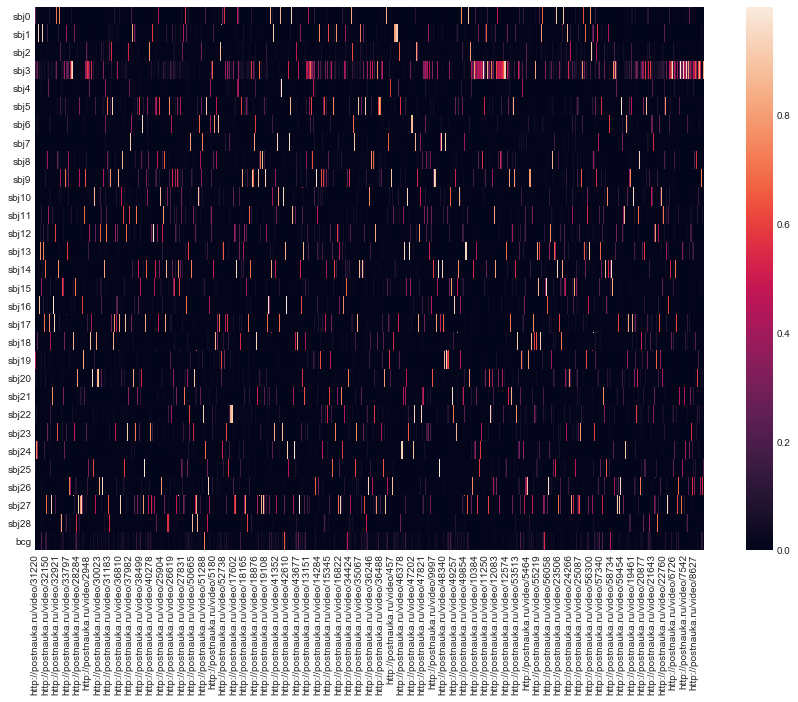

In [16]:
fig, ax = plt.subplots(figsize=(15,10))
seaborn.heatmap(tetha,ax=ax)


Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

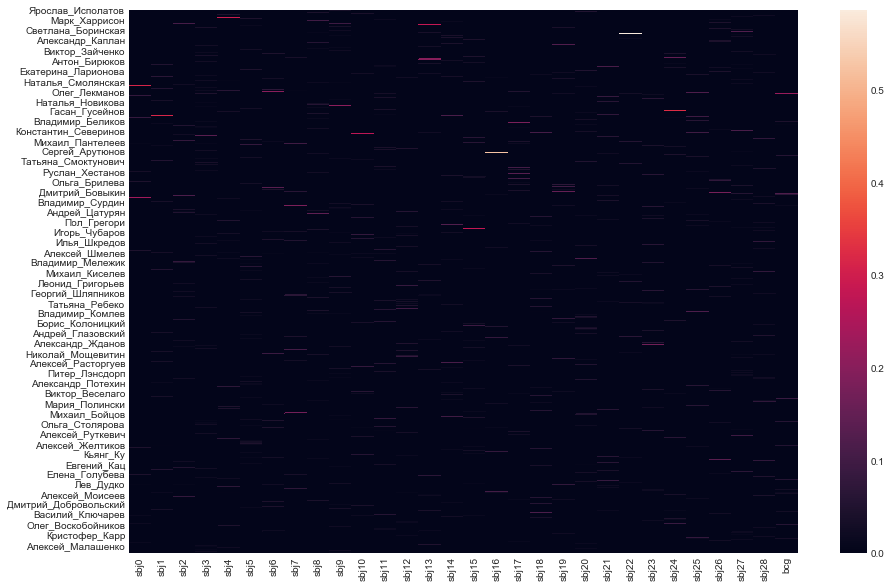

In [17]:
fig, ax = plt.subplots(figsize=(15,10))
seaborn.heatmap(phi_a,ax=ax)


Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [18]:
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances

In [19]:
mds = TSNE(metric="cosine")
profile = mds.fit_transform(phi_a)

Визуализируйте найденные двумерные представления с помощью функции scatter. 

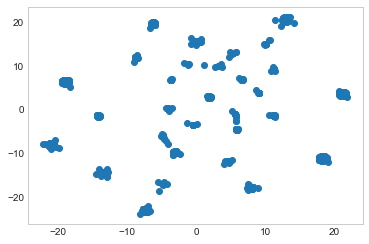

In [20]:
plt.scatter(profile[:,0], profile[:,1])
